# Results - CIViC smMIPs panel rescues clinically relevant variants

## Tools

In [1]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import seaborn as sns
sns.set(style='white')
sns.set_context("talk")

In [2]:
from pyliftover import LiftOver
lo = LiftOver('hg19', 'hg38')
li = LiftOver('hg38', 'hg19')

## Pull in Input Files

In [3]:
overlap_with_smmips = pd.read_csv('../output/variant_overlap.tsv', sep='\t')

In [4]:
samples_QC = pd.read_csv('../data/validation_samples/sequencing_quality_check.txt', sep='\t')

In [5]:
sample_info = pd.read_csv('../data/validation_samples/sample_dataframe.txt', sep='\t')

## smMIPs variant rescue for samples with both tumor and matched normal

In [6]:
overlap_with_smmips_data = overlap_with_smmips.merge(sample_info, right_on='Sample', left_on='sample')

In [7]:
tumor_normal_samples = []
for item in overlap_with_smmips_data[(overlap_with_smmips_data['Passed QC'] == 'yes') & (overlap_with_smmips_data['Matched Normal'] == 'yes')]['sample'].drop_duplicates():
    tumor_normal_samples.append(item)

In [8]:
def find_somatic_variants(name):
    print(name)
    
    to_iterate = []
    for item in glob.glob('../data/smmips_sequencing/*.vcf'):
        file_name = item.split('/')[-1].split('_')[0] +'_' + item.split('/')[-1].split('_')[1]
        if name == file_name:
            to_iterate.append(item)
    if len(to_iterate) != 4:
        print("Normal sequencing Failed for " + name + " ... skiping this sample")
        print()
        return 0,0
    else:
        tumor_variants = pd.DataFrame()
        normal_variants = pd.DataFrame()
        for item in to_iterate:
            current = pd.read_csv(item, sep='\t', comment='#', header=None).filter(items=[0,1,1,3,4])
            if len(current) > 1:
                if item.split('_')[3].split('.')[0] == 'T':
                    tumor_variants = tumor_variants.append(current)
                if item.split('_')[3].split('.')[0] == 'N':  
                    normal_variants = normal_variants.append(current)
        tumor_variants.columns = ['chrom', 'start', 'stop', 'reference', 'variant']
        normal_variants.columns = ['chrom', 'start', 'stop', 'reference', 'variant']
        
        print('Total tumor varinats: ', len(tumor_variants))
        
        somatic = tumor_variants.merge(normal_variants, how='outer', indicator=True)
        somatic = somatic[somatic['_merge'] == 'left_only']

        somatic.drop('_merge', axis=1).to_csv('../data/manual_review/' + name +'.bed.txt',sep='\t',index=False)
        print('Total somatic varinats: ', len(somatic))
        print()
        return 1, int(len(somatic))
    print()
    
    

In [9]:
eligible_samples = 0
total_variants = 0
for item in tumor_normal_samples:
    sample, somatic_variants = find_somatic_variants(item)
    eligible_samples += sample
    total_variants +=somatic_variants

SCLC_5
Total tumor varinats:  77
Total somatic varinats:  28

SCLC_8
Total tumor varinats:  66
Total somatic varinats:  11

SCLC_4
Total tumor varinats:  56
Total somatic varinats:  14

SCLC_3
Total tumor varinats:  64
Total somatic varinats:  16

SCLC_1
Total tumor varinats:  75
Total somatic varinats:  40

SCLC_2
Total tumor varinats:  62
Total somatic varinats:  17

SCLC_9
Total tumor varinats:  62
Total somatic varinats:  18

OSCC_5
Total tumor varinats:  56
Total somatic varinats:  4

SCLC_6
Total tumor varinats:  79
Total somatic varinats:  27

OSCC_1
Normal sequencing Failed for OSCC_1 ... skiping this sample

SCLC_7
Total tumor varinats:  161
Total somatic varinats:  88

OSCC_4
Total tumor varinats:  62
Total somatic varinats:  18

HL_1
Total tumor varinats:  59
Total somatic varinats:  29



In [10]:
print('Total samples with paired tumor/normal sequencing: ', eligible_samples)
print('Total stomatic variants identified exclusively on smMIPs: ', total_variants)

Total samples with paired tumor/normal sequencing:  12
Total stomatic variants identified exclusively on smMIPs:  310


# Determine Cause of Missed Variants

In [11]:
manual_review_dataframe = pd.DataFrame()
for item in glob.glob('../data/manual_review/*_postMR.bed.txt'):
    name = item.split('/')[3].split('.')[0].strip('_postMR')
    current_df = pd.read_csv(item,sep='\t')
    current_df['Sample'] = name
    manual_review_dataframe = manual_review_dataframe.append(current_df)

In [12]:
smMIPs_somatic = pd.DataFrame()
for name in tumor_normal_samples:
    to_iterate = []
    for item in glob.glob('../data/smmips_sequencing/*.vcf'):

        
        file_name = item.split('/')[-1].split('_')[0] +'_' + item.split('/')[-1].split('_')[1]

        if name == file_name:
            to_iterate.append(item)

    if len(to_iterate) != 4:
        continue

    else:
        tumor_variants = pd.DataFrame()
        normal_variants = pd.DataFrame()
        for item in to_iterate:
            current = pd.read_csv(item, sep='\t', comment='#', header=None).filter(items=[0,1,1,3,4,9])
            if len(current) > 1:
                if item.split('_')[3].split('.')[0] == 'T':
                    tumor_variants = tumor_variants.append(current)
                if item.split('_')[3].split('.')[0] == 'N':  
                    normal_variants = normal_variants.append(current)
        tumor_variants.columns = ['chrom', 'start', 'stop', 'reference', 'variant','GT:FALT:FTOT:RALT:RTOT:ALT:TOT:FRAC']
        normal_variants.columns = ['chrom', 'start', 'stop', 'reference', 'variant','GT:FALT:FTOT:RALT:RTOT:ALT:TOT:FRAC']

        somatic = tumor_variants.merge(normal_variants, how='outer', indicator=True)
        somatic = somatic[somatic['_merge'] == 'left_only']

        somatic['Sample'] = name

        smMIPs_somatic = smMIPs_somatic.append(somatic)

In [13]:
smMIPs_somatic['GT'], smMIPs_somatic['FALT'], smMIPs_somatic['FTOT'], smMIPs_somatic['RALT'], smMIPs_somatic['RTOT'], smMIPs_somatic['ALT'],smMIPs_somatic['TOT'],smMIPs_somatic['FRAC']  = smMIPs_somatic['GT:FALT:FTOT:RALT:RTOT:ALT:TOT:FRAC'].str.split(':', 8).str

In [14]:
smMIPs_somatic = smMIPs_somatic.drop(['GT:FALT:FTOT:RALT:RTOT:ALT:TOT:FRAC', '_merge'], axis=1)

In [15]:
manual_review_dataframe_merge = manual_review_dataframe.merge(smMIPs_somatic, how='outer', left_on=['Chromosome', 'Start', 'Stop', 'Reference', 'Variant', 'Sample'], right_on=['chrom', 'start', 'stop', 'reference', 'variant', 'Sample'],indicator=True)
manual_review_dataframe_merge = manual_review_dataframe_merge[manual_review_dataframe_merge['_merge'] == 'both']

In [16]:
manual_review_dataframe_merge.to_csv('../data/manual_review/manual_review_matrix.txt', sep='\t', index=False)

In [17]:
len(manual_review_dataframe_merge)

310

## Analysis of germline variants

In [18]:
#GERMLINE VARIANTS

print('Total Germline Variants: ',len(manual_review_dataframe_merge[manual_review_dataframe_merge['Notes'] == 'Germline']))

print(len(manual_review_dataframe_merge[manual_review_dataframe_merge['Notes'] == 'Germline'])/len(manual_review_dataframe_merge)*100,'%')

Total Germline Variants:  55
17.741935483870968 %


In [19]:
germline_variants = manual_review_dataframe_merge[manual_review_dataframe_merge['Notes'] == 'Germline']

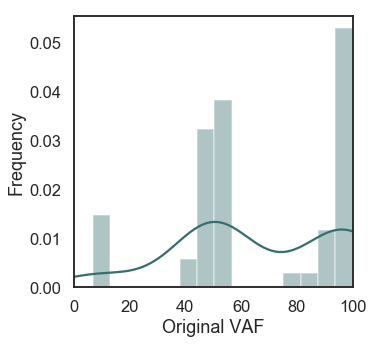

In [20]:
plt.figure(figsize=(5,5))
ax = sns.distplot(pd.to_numeric(germline_variants['FRAC'])*100, bins=15, color='#376E6F')
ax.set_xlim([0, 100])
plt.xlabel('Original VAF')
plt.ylabel('Frequency')
plt.savefig('../data/Figures/Recovery_germline.pdf', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

## Analysis of variants with sequencing artifacts 

In [21]:
#SEQUENCING ARTIFACTS

artifacts = manual_review_dataframe_merge[manual_review_dataframe_merge['Notes'] == 'Sequencing artifact']


print('Total Sequencing Artifact Variants: ',len(artifacts))

print(len(artifacts)/len(manual_review_dataframe)*100,'%')

Total Sequencing Artifact Variants:  36
11.612903225806452 %


In [22]:
tags_list = {'MN':'#0E1A1A', 'MM':'#152627', 'DN':'#1C3334', 'D':'#495C5D', 'MV':'#778585', 'TR':'#A4ADAE', }

In [23]:
tags = []
for item in artifacts['Tags'].values:
    for item in item.split(','):
        tags.append(item)


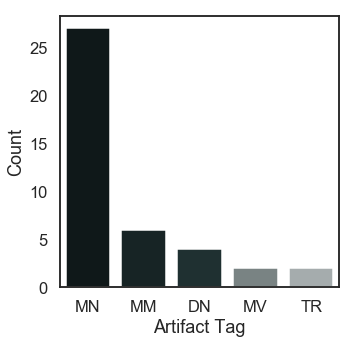

In [24]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x=tags, palette=tags_list, order=['MN', 'MM', 'DN', 'MV', 'TR'])
# ax.set_xticklabels(['Mononucleotide', 'Multiple Mismatches', 'Dinucleotide', 'Multiple Variants', 'Tandem Repeat'])
plt.xlabel('Artifact Tag')
plt.ylabel('Count')
plt.savefig('../data/Figures/Recovery_artifact.pdf', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

## Analysis of variants not called as somatic on original sequencing

In [25]:
other = len(manual_review_dataframe) - (len(germline_variants) + len(artifacts))
print('Total Variants not called as somatic by original sequencing: ',other)
print(other/len(manual_review_dataframe)*100,'%')

Total Variants not called as somatic by original sequencing:  219
70.64516129032258 %


###  Analysis of variants with no support on original sequencing

In [26]:
not_observed = manual_review_dataframe_merge[manual_review_dataframe_merge['Notes'] == 'No support']
print('Total Variants not observed on original sequencing: ',len(not_observed))
print(len(not_observed)/len(manual_review_dataframe)*100,'%')

Total Variants not observed on original sequencing:  175
56.451612903225815 %


In [27]:
np.median((pd.to_numeric(not_observed['FRAC']))*100)

0.082690187431091494

In [28]:
count = 0
insufficient_coverage = 0
total = 0
for i,row in not_observed.iterrows():
    if float(row['ALT']) > 2:
        count += 1
    total +=1
    smMIPs_VAF = float(row['FRAC'])
    original_tumor_coverage = float(row['tumor coverage'])
    if original_tumor_coverage == 0:
        insufficient_coverage +=1
    else:
        if 1/original_tumor_coverage > smMIPs_VAF:
            insufficient_coverage +=1

print(count)

175


In [29]:
print('Variants with insufficient coverage: ' + str(insufficient_coverage/total))

Variants with insufficient coverage: 0.9257142857142857


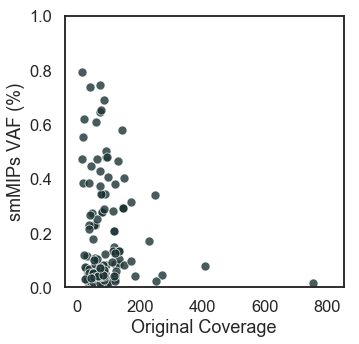

In [30]:
plt.figure(figsize=(5,5))
ax = sns.scatterplot(x="tumor coverage", y=pd.to_numeric(not_observed["FRAC"])*100, data=not_observed, alpha=0.8, color='#1C3334')
ax.set_ylim([0, 1])
plt.xlabel('Original Coverage')
plt.ylabel('smMIPs VAF (%)')
plt.savefig('../data/Figures/Recovery_no-support.pdf', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

###  Analysis of variants with support on original sequencing

In [31]:
original_support = manual_review_dataframe_merge[manual_review_dataframe_merge['Notes'] == 'Support']

In [32]:
print('Total Variants not observed on original sequencing: ',len(original_support))
print(len(original_support)/len(manual_review_dataframe)*100,'%')

Total Variants not observed on original sequencing:  43
13.870967741935484 %


In [33]:
smmips_fraction = []
for item in original_support['FRAC']:
    smmips_fraction.append(float(item) * 100)

original_support['smMIPs VAF'] = smmips_fraction

/Users/ebarnell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [34]:
correlation_original = original_support.filter(items=['original_VAF', 'smMIPs VAF'])
pd.DataFrame.corr(correlation_original,method='pearson')

,original_VAF,smMIPs VAF
original_VAF,1.000000,0.928133
smMIPs VAF,0.928133,1.000000


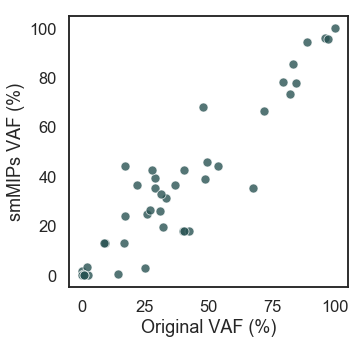

In [35]:
plt.figure(figsize=(5,5))
sns.scatterplot(x="original_VAF", y="smMIPs VAF", data=original_support, alpha=0.8, color='#295353')
plt.xlabel('Original VAF (%)')
plt.ylabel('smMIPs VAF (%)')
plt.savefig('../data/Figures/Recovery_support.pdf', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

In [36]:
original_support.to_csv('../output/recovered_supported_variants.tsv', sep='\t', index=False)

#### Evaluate manual review of supported variants

In [37]:
analysis = pd.read_csv('../output/analysis_of_original_MR.txt', sep='\t')

In [38]:
analysis.groupby('Notes').size()

Notes
failed MR      2
filtered       9
not called     4
somatic       28
dtype: int64